# 1 - Análisis estadístico a dataset Airbnb

# Montar directorio de Google Drive

In [ ]:
## Solicitar acceso y montar en el sistema tu directorio de Google Drive
# Esto permitirá la persistencia de datos entre distintas sesiones
import os, sys
from google.colab import drive
drive.mount('/content/drive')

# Creamos un directorio para este cuaderno y lo asociamos
drive_path = '/content/drive/MyDrive/Colab Notebooks/iabd-sbd'
nb_path = '/content/iabd-sbd'

if not os.path.exists(drive_path):
    os.makedirs(drive_path)
os.symlink(drive_path, nb_path)
sys.path.insert(0,nb_path)

%cd $nb_path

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks/iabd-sbd


# Instalación de spark en Google Colab

In [ ]:
# Spark está escrito en el lenguaje de programación Scala, por lo que requiere
# de una máquina virtual de Java (JVM) para funcionar. Por lo tanto, lo primero
# es instalar java:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

In [ ]:
## Instalación de Apache Spark en Google Colab (Ejecutar solo si no se ha realizado nunca)
# Nota: Puede tardar unos minutos (se paciente)
# El siguiente paso es elegir una versión reciente de spark
# En este notebook, se usará spark versión 3.1.2, la cual puede descargarse en:
spark_file = 'spark-3.3.2-bin-hadoop3.tgz'
spark_url = 'https://archive.apache.org/dist/spark/spark-3.3.2/' + spark_file

# A continuación, descargamos la versión elegida de spark:
import os # Libreria de manejo del sistema operativo
os.system("wget -q {spark_url} -P " + nb_path) # Realizamos la descarga
os.system("tar xf " + nb_path + "/" + spark_file) # Descomprimimos el fichero .tgz

# Realizamos la instalación de pyspark utilizando la herramienta pip
!pip install --target=$nb_path -q pyspark
!pip install -q findspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 4.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.5/200.5 kB 17.2 MB/s eta 0:00:00


In [ ]:
# Damos permisos de ejecución
!chmod -R +x ./pyspark/

# Finalmente, es necesario definir algunas variables de entorno en el sistema
# operativo para poder usar spark correctamente:
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = nb_path + "/pyspark"

# Descargar el dataset
(si no se ha realizado antes)

### Dataset: Madrid Airbnb
https://www.kaggle.com/rusiano/madrid-airbnb-data/

###Descripción:
Los archivos se han descargado de insideairbnb.com y ofrecen una instantánea de la situación de Madrid el 13 de abril de 2021.

El archivo 'listings' contiene todos los anuncios en Madrid el 13 de abril de 2021 (~19k). El archivo 'listings_details' contiene variables adicionales. El calendario ('calendar') tiene 365 registros para cada anuncio y especifica si el anuncio está disponible en un día concreto y el precio en ese día. Además, hay un archivo de reseñas ('reviews'), y también he incluido un .geojson con información geográfica de los barrios de Madrid.

In [ ]:
# Descargar el dataset que se utilizará utiliznado un enlace compartido de google drive
# Si la URL es https://drive.google.com/uc?id=IDFICHEROCOMPARTIDO se debe utilizar:
# !gdown --id IDFICHEROCOMPARTIDO
!gdown --id 1WAfS7AnQjLjocyUDnsN7q26Dzi9nQSKK

# El fichero puede descargarse manualmente en https://drive.google.com/uc?id=1WAfS7AnQjLjocyUDnsN7q26Dzi9nQSKK
# Nota: En el dataset original de airbnb se utiliza ',' como separador entre
# campos del CSV, sin embargo, en el dataset proporcionado, se ha decidido
# modificar este caracter por tabulaciones '\t', para evitar problemas a la hora
# de su lectura por Spark.

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1WAfS7AnQjLjocyUDnsN7q26Dzi9nQSKK
To: /content/drive/MyDrive/Colab Notebooks/iabd-sbd/listings.csv
100% 2.90M/2.90M [00:00<00:00, 157MB/s]


In [ ]:
# Comprobar archivos descargados
!ls -la

total 2859
drwx------  2 root root    4096 May  9 17:55 bin
-rw-------  1 root root 2902908 May 10 18:23 listings.csv
drwx------  2 root root    4096 May  9 17:55 py4j
drwx------  2 root root    4096 May  9 17:55 py4j-0.10.9.7.dist-info
drwx------ 18 root root    4096 May  9 17:55 pyspark
drwx------  2 root root    4096 May  9 17:55 pyspark-3.4.0.dist-info
drwx------  2 root root    4096 May  9 17:55 share


# Trabajando con datasets en Spark

In [ ]:
# Importar pyspark.sql
from pyspark.sql import*

# Importar SparkContext and SparkConf
from pyspark import SparkContext, SparkConf

El primer paso será configurar una nueva sesión de Spark. Para configurar los parámetros de la sesión Spark utiliza pares clave-valor.

Primero, creamos un objeto SparkConf, el cual nos permitirá definir las propiadades de la sesión. Estas propiades contienen información sobre la aplicación que se desea crear. Se puede encadenar la definición de varias propiedades para reducir de esta manera el número de líneas y de código necesario. En este caso, hemos definido dos propiedades: la URL de conexión y el nombre de la aplicación.

Mediante setMaster() especificamos la URL en la que usaremos Spark, en este caso lo usaremos en local. Mediante setAppName especificamos un nombre para la aplicación.

Una vez se ha definido la configuración de Spark se debe crear un SparkContext, el cual indicara a Spark como acceder al cluster. Pedemos crear un nuevo objeto SparkContext o utilizar la función getOrCreate para comprobar primero si ya existe este cluster y en el caso contrario crear uno nuevo.

In [ ]:
# Establecer las propiedades de Spark:
# - URL de conexión
# - Nombre de la aplicación
conf = SparkConf().setMaster("local").setAppName("1-Analisis_Estadistico_Airbnb")

# Iniciar un cluster de Spark (puede tardar unos minutos)
# Comprobar si ya existe este cluster y en el caso contrario crear uno nuevo
sc = SparkContext.getOrCreate(conf=conf)

# Mostramos el cluster creado
sc

<SparkContext master=local appName=1-Analisis_Estadistico_Airbnb>

Una de las funcionalidades clave de Spark es su capacidad de ejecutar consultas SQL utilizando sentencias básicas SQL o HiveQL. Cuando se ejecuta una sentencia SQL en Spark, obtenemos como resultado un dataframe. Un dataframe es una coleción de datos distribuida que se organiza en columnas. Este es un concepto equivalente al concepto de tabla en una base de datos relacional, o al concepto de dataframe del paquete pandas en Python. Pese al parecido de estos dataframes con los dataframes del paquete pandas, Spark implementa un gran número de optimizaciones que permiten que sean adecuados para grandes datasets. Podemos crear un dataframe a partir de varias fuentes de datos como ficheros de datos, tablas en Hive, bases de datos externas, u otras estructuras de Spark como RDDs.

Para poder definir un dataframe o ejecutar cualquier consulta SQL en Spark, primero tenemos que crear un objeto SQLContext a partir del cluster de Spark creado anteriormente.

In [ ]:
# Inicializar SQLContext a partir del cluster Spark creado anteriormente
sqlContext = SQLContext(sc)

/content/iabd-sbd/pyspark/sql/context.py:112: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [ ]:
# Creamos un dataframe a partir del archivo CSV descargado anteriormente y
# que contiene el dataset que utilizaremos en esta sesión
df = sqlContext.read.csv('listings.csv', header=True, sep="\t", inferSchema = "true")

# Mostrar el contenido del dataframe
df.show()

+---+-----+--------------------+---------+---------+--------------------+--------------+--------+---------+---------------+-----+--------------+-----------------+-----------+-----------------+------------------------------+----------------+
|_c0|   id|                name|  host_id|host_name| neighbourhood_group| neighbourhood|latitude|longitude|      room_type|price|minimum_nights|number_of_reviews|last_review|reviews_per_month|calculated_host_listings_count|availability_365|
+---+-----+--------------------+---------+---------+--------------------+--------------+--------+---------+---------------+-----+--------------+-----------------+-----------+-----------------+------------------------------+----------------+
|  0| 6369|Rooftop terrace r...|    13660|    Simon|           Chamartín|Hispanoamérica|40.45724| -3.67688|   Private room|   60|             1|             78.0| 2020-09-20|             0.58|                             1|             180|
|  1|21853|Bright and airy room|    

In [ ]:
# Mostrar un esquema de los atributos contenidos en el dataframe junto con su tipo
df.printSchema()

root
 |-- _c0: string (nullable = true)
 |-- id: integer (nullable = true)
 |-- name: string (nullable = true)
 |-- host_id: string (nullable = true)
 |-- host_name: string (nullable = true)
 |-- neighbourhood_group: string (nullable = true)
 |-- neighbourhood: string (nullable = true)
 |-- latitude: string (nullable = true)
 |-- longitude: double (nullable = true)
 |-- room_type: string (nullable = true)
 |-- price: integer (nullable = true)
 |-- minimum_nights: string (nullable = true)
 |-- number_of_reviews: double (nullable = true)
 |-- last_review: string (nullable = true)
 |-- reviews_per_month: double (nullable = true)
 |-- calculated_host_listings_count: integer (nullable = true)
 |-- availability_365: integer (nullable = true)



In [ ]:
# Convertir la columna "minimum_nights" en entero
df = df.withColumn("minimum_nights", df["minimum_nights"].cast('int'))
df.printSchema()

root
 |-- _c0: string (nullable = true)
 |-- id: integer (nullable = true)
 |-- name: string (nullable = true)
 |-- host_id: string (nullable = true)
 |-- host_name: string (nullable = true)
 |-- neighbourhood_group: string (nullable = true)
 |-- neighbourhood: string (nullable = true)
 |-- latitude: string (nullable = true)
 |-- longitude: double (nullable = true)
 |-- room_type: string (nullable = true)
 |-- price: integer (nullable = true)
 |-- minimum_nights: integer (nullable = true)
 |-- number_of_reviews: double (nullable = true)
 |-- last_review: string (nullable = true)
 |-- reviews_per_month: double (nullable = true)
 |-- calculated_host_listings_count: integer (nullable = true)
 |-- availability_365: integer (nullable = true)



In [ ]:
# Mostrar las columnas "id", "host_name", "neighbourhood" y "price"
df.select("id","host_name","neighbourhood","price").show()

+-----+---------+--------------+-----+
|   id|host_name| neighbourhood|price|
+-----+---------+--------------+-----+
| 6369|    Simon|Hispanoamérica|   60|
|21853|    Abdel|      Cármenes|   31|
|23001|    Jesus|       Legazpi|   50|
|24805|        A|   Universidad|   92|
|26825| Agustina|       Legazpi|   26|
|28200|    Jesus|       Legazpi|   85|
|30320|     Dana|           Sol|   65|
|30959|   Angela|   Embajadores|   54|
|37859|    Nacho|       Palacio| 1400|
|40718|     Luis|      Justicia|   79|
|40916|     Dana|   Universidad|   90|
|47957|   Sergio|          Goya|   82|
|59923|     null|       Palacio|   40|
|62423|   Arturo|      Justicia|   24|
|64131|     Gina|    Peñagrande|   21|
|70059|    Diana|   Universidad|   51|
|70316|   Raquel|       Palacio|   75|
|72150|      Vin|   Embajadores|  139|
|74352|     Juan|   Embajadores|   80|
|75609| Mercedes|   Embajadores|   63|
+-----+---------+--------------+-----+
only showing top 20 rows



## Limpieza de datos

In [ ]:
# Eliminamos la columna "name"
df = df.drop("name")

# Tratar las columnas con valores nulos:

# Alternativa 1: Remplazar los valores nulos por un valor concreto.
# Vamos a remplazar los valores nulos en "minimum_nights" por el valor 0:
df = df.fillna("0", subset = ["minimum_nights"])

# Alternativa 2: Eliminamos las filas que contienen valores nulos.
# Si se quiere eliminar las filas que contengan algún valor nulo en alguna
# columna específica, por ejemplo en "price" y "minimum_nights", usaríamos:
# df = df.na.drop(subset = ["price", "minimum_nights"])

# Si se quiere eliminar todas las filas que contengan algún valor nulo en
# cualquier columna, ejecutamos:
df = df.na.drop()

# Notar que previamente hemos remplazado los valores nulos en "minimum_nights"
# por un 0, por lo tanto estas filas ya no serían eliminadas en la última instrucción.

In [ ]:
# Obtener las dimensiones del dataframe
print("Número de filas: {filas:d};  Número de columnas: {columnas:d}".format(
    filas=df.count(), columnas=len(df.columns)
))

Número de filas: 13547;  Número de columnas: 16


In [ ]:
# Guardar en la variable "ofertas_lujo" los anuncios de pisos/casas completas
# con un precio mayor o igual a 1000 euros
ofertas_lujo = df.filter((df["room_type"] == "Entire home/apt") & (df["price"] >= 1000))

# Ahora, eliminar anuncios con 0 comentarios (reviews)
ofertas_lujo = ofertas_lujo.filter(ofertas_lujo["number_of_reviews"] > 0)

# Mostrar las dimensiones
print("Número de filas: {filas:d};  Número de columnas: {columnas:d}".format(
    filas=ofertas_lujo.count(), columnas=len(ofertas_lujo.columns)
))

# Mostrar estos anuncios
ofertas_lujo.show()

Número de filas: 89;  Número de columnas: 16
+----+--------+--------+--------------+-------------------+-------------+--------+---------+---------------+-----+--------------+-----------------+-----------+-----------------+------------------------------+----------------+
| _c0|      id| host_id|     host_name|neighbourhood_group|neighbourhood|latitude|longitude|      room_type|price|minimum_nights|number_of_reviews|last_review|reviews_per_month|calculated_host_listings_count|availability_365|
+----+--------+--------+--------------+-------------------+-------------+--------+---------+---------------+-----+--------------+-----------------+-----------+-----------------+------------------------------+----------------+
| 181|  578731| 2847013|      Santiago|             Centro|  Universidad|40.42551| -3.70812|Entire home/apt| 9999|             2|            338.0| 2020-03-15|             3.19|                             5|             105|
| 412| 1101760| 2847013|      Santiago|            

In [ ]:
# Ahora, eliminar aquellos anuncios con menos de 10 comentarios (reviews)
ofertas_lujo = ofertas_lujo.filter(ofertas_lujo["number_of_reviews"] > 10)

# Mostrar las dimensiones
print("Número de filas: {filas:d};  Número de columnas: {columnas:d}".format(
    filas=ofertas_lujo.count(), columnas=len(ofertas_lujo.columns)
))

Número de filas: 47;  Número de columnas: 16


In [ ]:
# Agrupar los anuncios de alojamientos de lujo obtenidos en el paso anterior
# por número de mínimo de noches ofertadas. Contar el número de anuncios por
# cada grupo (número mínimo de noches)
ofertas_lujo.groupBy("minimum_nights").count().show()

+--------------+-----+
|minimum_nights|count|
+--------------+-----+
|             1|   22|
|             3|    2|
|           100|    1|
|          1000|    1|
|            90|    1|
|             2|   19|
|            30|    1|
+--------------+-----+



## Preparar el dataset para aplicar técnicas de machine learning con Spark

En Spark, los algoritmos de machine learning y las técnicas estadísticas trabajan con vectores de características. Un vector de características puede entenderse como una fila de un dataset, en el que cada una de las columnas representan las características (*features* en inglés). Por lo tanto, en Spark será necesario convertir nuestro dataframe en vectores, donde cada uno de los componentes (los elementos) del vector se denominan escalares. Más concretamente, en Spark un vector se define mediante lo que se denomina *DenseVector*, y cada uno de los valores de estos vectores son elementos de tipo *double*.

Veamos un ejemplo de vector en Spark:

In [ ]:
# Ejemplo de creación de DenseVector
from pyspark.ml.linalg import Vectors

mi_vector = Vectors.dense([1.0, 2.0, 3.0])
print(mi_vector)

[1.0,2.0,3.0]


Los vectores pueden concatenerse en columnas, y posteriormente pueden convertirse en dataframes.

"Row" permite crear un objeto fila de un dataframe, donde cada característica (o columna) se define como una variable: nombre_columna = valor_columna.

"sc.parallelize" permite copiar los elementos de una colección para formar un conjunto de datos distribuido con el que se puede operar en paralelo. A continuación, podemos generar un dataframe mediante la función "toDF()".

In [ ]:
from pyspark.sql import Row

mi_df = sc.parallelize([Row(id=1, features=mi_vector),
                        Row(id=2, features=Vectors.dense([1.0, 1.0, 1.0])),
                        Row(id=50, features=Vectors.dense([4.0, 5.0, 6.0]))]
                       ).toDF()

mi_df.show()

+---+-------------+
| id|     features|
+---+-------------+
|  1|[1.0,2.0,3.0]|
|  2|[1.0,1.0,1.0]|
| 50|[4.0,5.0,6.0]|
+---+-------------+



## Transformers y estimators

A continuación, vamos a ver como podemos transformar un dataframe en un vector de características utilizando un DenseVector de elementos de tipo Double. Para ello, vamos a introducir primero el concepto de *ML Pipelines*. En machine learning, una pipeline es una forma de codificar y automatizar el flujo de trabajo necesario para producir un modelo de aprendizaje automático. En Spark, las ML Pipelines proporcionan un conjunto uniforme de APIs de alto nivel construidas sobre DataFrames y que permiten aplicar una serie de operaciones sobre los datos que denominamos *transformers* o *estimators*.


*   Un transformer es un algoritmo que toma como entrada un dataframe, aplica una serie de operaciones a los datos y devuelve otro dataframe.
*   Un estimator es un algoritmo que se aplica a un dataframe para producir otro transformer.

Uno de los transformers más útilizados se denomina **VectorAssembler**. Esta función se encarga de tomar una serie de columnas de un dataframe como entrada y genera una nueva columna en el dataframe, la cual contiene un vector del tipo DenseVector conteniendo todas las características indicadas. Un aspecto importante sobre la función VectorAssembler es que solo permite columnas que tengan datos que sean de los tipos: integer (entero), long (entero largo), double (coma flotante), boolean (boleano) y vecotres. Los datos que sean del tipo fecha, cadenas de texto, marcas de tiempo, etc, no pueden ser convertidos en vectores, ya que los vectores solo pueden tener valores numéricos. Más adelante, veremos como podemos introducir cadenas de texto mediante una técnica llamada one-hot-encoding.

En la siguiente celda de código se puede observar como transformar las columnas "price", "minimum_nights", "number_of_reviews", "reviews_per_month" y "availability_365" en un vector que que contiene cada una de estas columnas. Este vector se añade al dataframe original bajo la columna "features", generando un nuevo dataframe que hemos denominado *assempled_df*.


In [ ]:
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(
  inputCols = ["price", "minimum_nights", "number_of_reviews", "reviews_per_month", "availability_365"],
  outputCol = "features"
)
assembled_df = assembler.transform(df)

# Mostramos la nueva columa "features" para las 10 primeras filas del dataset
assembled_df.select("features").show(10, truncate=False)


+---------------------------+
|features                   |
+---------------------------+
|[60.0,1.0,78.0,0.58,180.0] |
|[31.0,4.0,33.0,0.42,364.0] |
|[92.0,5.0,10.0,0.13,72.0]  |
|[26.0,2.0,149.0,1.12,365.0]|
|[85.0,1.0,3.0,0.03,365.0]  |
|[65.0,5.0,170.0,1.29,351.0]|
|[54.0,3.0,8.0,0.11,0.0]    |
|[79.0,3.0,118.0,0.91,302.0]|
|[90.0,5.0,48.0,0.38,346.0] |
|[82.0,10.0,55.0,0.44,319.0]|
+---------------------------+
only showing top 10 rows



## Variables categóricas



Una variable categórica es una variable que puede tomar un conjunto limitado (y por lo general fijo) de valores posibles. Un ejemplo de esto sería nuestra variable "room_type" que indica el tipo de apartamento o habitación que se está ofertando. Cuando tenemos un dataset con variables categóricas, es importante transformarlas a una representación numérica que pueda ser utilizada por los algoritmos de machine learning.

Transformar cada categoría en un valor númerico no es una buena solución, ya que los algoritmos de machine learning interpretarían una correlación entre los valores, asumiendo que dos valores más proximos entre si están correlacionados. Por ejemplo, imaginar que tenemos una carasterística categórica "color" que pudiera tomar los valores: rojo, verde, azul y blanco, y mapeamos esta categoría a los valores 1, 2, 3 y 4 respectivamente. Un algoritmo de machine learning interpretaría que el número 4, correspondiente con el color blanco, estaría más próximo al color azul, que tiene el valor 3, que al color rojo, que tiene valor 1. Esto daría lugar a estimaciones muy pobres. Para solucionar esto, se recurre a transformaciones en las cuales las variables categoricas se convierten en un subespacio en el que la distancia entre cada valor sea el mismo.

Una de las transformaciones más utlizados para tratar con estas variables categóricas es el denominado One Hot Encoding. Esta transformación obtiene como entrada el índice de cada categoría y la transforma en un vector binario, dónde cada elemento representa un valor categórico. Este vector contendrá zeros en todos sus elementos salvo en el que corresponda con el índice transformado.

Volviendo al ejemplo anterior, ahora la transformación de la variable categórica blanco sería el vector `[0, 0, 0, 1]`, mientras que el color azul sería `[0, 0, 1, 0]`. Notar que la distancia entre ambos vectores es la misma.

A continuación, vamos a presentar dos nuevos transformers de la ML Pipeline de Spark que nos van a permitir trabajar con datos de formato String que representen categorías.  El primer transformer se denomina *StringIndexer* y nos permite transformar etiquetas en formato string (texto) en índices numéricos. El segundo transformer se denomina *OneHotEncoder* y nos permite transformar los índices numéricos obtenidos anteriormente en un vector en formato One Hot Encoding, donde tendremos un elemento del vector por cada valor de la variable categórica de entrada.

Spark, genera un vector *sparse* cuando se ejecuta OneHotEncoder, evitando así almacenar la gran cantidad de ceros que genera esta transformación y reduciendo la memoria del sistema. Por lo tanto, su representación en el dataframe aparece de manera diferente.

Veamos como podemos transformar nuestra variable "room_type" utilizando OneHotEnocoder:

In [ ]:
from pyspark.ml.feature import StringIndexer

# Creamos un objeto StringIndexer para la columna "room_type"
indexer_room_type = StringIndexer(inputCol="room_type", outputCol="room_type_idx")
# A continuación, realizamos la transformación
df1 = indexer_room_type.fit(df).transform(df)

df1.show()
# Private room --> 1.0, etc...

+---+-----+---------+---------+--------------------+--------------+--------+---------+---------------+-----+--------------+-----------------+-----------+-----------------+------------------------------+----------------+-------------+
|_c0|   id|  host_id|host_name| neighbourhood_group| neighbourhood|latitude|longitude|      room_type|price|minimum_nights|number_of_reviews|last_review|reviews_per_month|calculated_host_listings_count|availability_365|room_type_idx|
+---+-----+---------+---------+--------------------+--------------+--------+---------+---------------+-----+--------------+-----------------+-----------+-----------------+------------------------------+----------------+-------------+
|  0| 6369|    13660|    Simon|           Chamartín|Hispanoamérica|40.45724| -3.67688|   Private room|   60|             1|             78.0| 2020-09-20|             0.58|                             1|             180|          1.0|
|  1|21853|    83531|    Abdel|              Latina|      Cármen

In [ ]:
from pyspark.ml.feature import OneHotEncoder

# Ahora creamos un objeto OneHotEncoder
onehotencoder_room_type = OneHotEncoder(inputCol="room_type_idx", outputCol="room_type_vec")
# Realizamos la transformación
df2 = onehotencoder_room_type.fit(df1).transform(df1)

# Mediante la función distinct() podemos visualiar los diferentes valores posibles
# de la variable categórica. Podemos ver así la transformación que se ha realizado.
# Notar que el vector generado está en formato sparse, por lo que su representación
# es diferente.
df2.select("room_type", "room_type_idx", "room_type_vec").distinct().show()

+---------------+-------------+-------------+
|      room_type|room_type_idx|room_type_vec|
+---------------+-------------+-------------+
|Entire home/apt|          0.0|(3,[0],[1.0])|
|   Private room|          1.0|(3,[1],[1.0])|
|     Hotel room|          3.0|    (3,[],[])|
|    Shared room|          2.0|(3,[2],[1.0])|
+---------------+-------------+-------------+



## ML Pipeline

Por último, vamos a ver como unificar todas las transformaciones anteriores en un solo paso utilizando la ML Pipeline de Spark.

En nuestro caso, queremos realizar tres transformaciones en los datos, cada una de las cuales conformará una etapa del pipeline:

*   Etapa 1: Aplicar la transformación StringIndexer sobre la columna "room_type" para transformar las categorías de string a valores enteros.
*   Etapa 2: Aplicar la técnica One Hot Encoding a la columna "room_type" transformada en variable numérica.
*   Etapa 3: Crear un vector con todas las características que queremos utilizar en los análisis posteriores mediante el uso del transformer VectorAssembler.

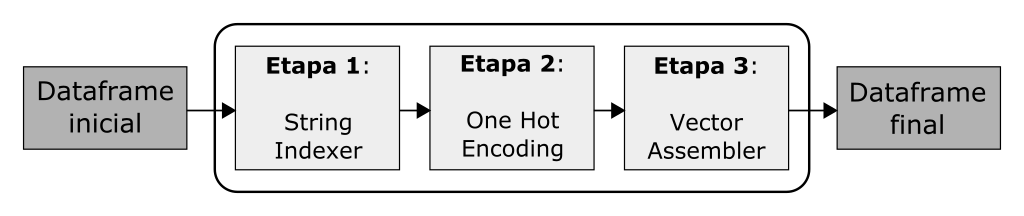

Una vez se ha definido el pipeline, el últio paso será aplicarlo sobre el dataframe *df*, obteniendo otro dataframe transformado que hemos denominado *assembled_df*.

In [ ]:
from pyspark.ml import Pipeline

# Etapa 1: Transformar la columna "room_type" en númerica
indexer_room_type = StringIndexer(inputCol="room_type", outputCol="room_type_idx")
# Etapa 2: Aplicar One Hot Encoding a la variable categórica númerica "room_type_idx"
onehotencoder_room_type = OneHotEncoder(inputCol="room_type_idx", outputCol="room_type_vec")
# Etapa 3: Crear el vector de características que utilizaremos más tarde
assembler = VectorAssembler(
  inputCols = ["price", "minimum_nights", "number_of_reviews", "reviews_per_month", "availability_365", "room_type_vec"],
  outputCol = "features"
)

# Cremos la ML Pipeline
pipeline = Pipeline(stages=[indexer_room_type, onehotencoder_room_type, assembler])

# Aplicamos la función fit del pipeline a los datos
model = pipeline.fit(df)
# Transformamos los datos y obtenemos el dataset transformado: "assembled_df"
assembled_df = model.transform(df)

# Visualizamos el dataset generado
assembled_df.show(10, truncate=False)

+---+-----+---------+---------+-------------------+--------------+--------+---------+---------------+-----+--------------+-----------------+-----------+-----------------+------------------------------+----------------+-------------+-------------+---------------------------------------+
|_c0|id   |host_id  |host_name|neighbourhood_group|neighbourhood |latitude|longitude|room_type      |price|minimum_nights|number_of_reviews|last_review|reviews_per_month|calculated_host_listings_count|availability_365|room_type_idx|room_type_vec|features                               |
+---+-----+---------+---------+-------------------+--------------+--------+---------+---------------+-----+--------------+-----------------+-----------+-----------------+------------------------------+----------------+-------------+-------------+---------------------------------------+
|0  |6369 |13660    |Simon    |Chamartín          |Hispanoamérica|40.45724|-3.67688 |Private room   |60   |1             |78.0             

# Análisis estadístico con Spark

## Otención de los principales estadísticos descriptivos

In [ ]:
# METODO 1: Utilizando la función summary sobre el dataset

# Obtener los principales estadísticos descriptivos de las variables "price",
# "minimum_nights", "number_of_reviews", "reviews_per_month" y "availability_365"
df.select("price", "minimum_nights", "number_of_reviews", "reviews_per_month", "availability_365").summary().show()

+-------+------------------+------------------+-----------------+------------------+------------------+
|summary|             price|    minimum_nights|number_of_reviews| reviews_per_month|  availability_365|
+-------+------------------+------------------+-----------------+------------------+------------------+
|  count|             13547|             13547|            13547|             13547|             13547|
|   mean|107.09345242489113| 5.696833247213405| 44.7601683029453|1.1237425260205165|155.41485199675205|
| stddev| 479.8354842651087|33.180229747631216|72.31591218457794| 1.350697493419991| 141.3075517939122|
|    min|                 8|                 1|              1.0|              0.01|                 0|
|    25%|                35|                 1|              3.0|              0.17|                 0|
|    50%|                56|                 2|             13.0|              0.58|               118|
|    75%|                90|                 3|             55.0

In [ ]:
# METODO 2: Utilizando la biblioteca de machine learning de PySpark
from pyspark.ml.stat import Summarizer

# Obtener la media de todos los atributos en la columna "features"
assembled_df.select(Summarizer.mean(assembled_df["features"])).show(truncate=False)

+------------------------------------------------------------------------------------------------------------------------------------------------------+
|mean(features)                                                                                                                                        |
+------------------------------------------------------------------------------------------------------------------------------------------------------+
|[107.0934524248912,5.696833247213394,44.7601683029453,1.1237425260205156,155.4148519967525,0.6182180556580793,0.3590462833099579,0.015280135823429542]|
+------------------------------------------------------------------------------------------------------------------------------------------------------+



In [ ]:
# Obtener varios estadísticos: La media, desviación estandar, varianza, valor
# mínimo, valor máximo y número de elementos en la muestra.
summarizer = Summarizer.metrics("mean", "std", "variance", "min", "max", "count")
assembled_df.select(summarizer.summary(assembled_df["features"])).show(truncate=False)

+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|aggregate_metrics(features, 1.0)                                                                                                                                                                                                                                                                                                                                                                                                                           

Para más información sobre las métricas disponibles, consultar la documentación oficial en:
https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.stat.Summarizer.html

## Muestreo de datos

Spark incorpora algunas funciones que permiten realizar un muestreo de los datos. Recordar que denominamos muestreo a la técnica estadística utilizada para seleccionar una muestra a partir de una población. Existen numerosos tipos de muestreo, pero en esta sección se van a introducir los tres tipos muestreos que incorporan los dataframes de Spark:

*   **Muestreo aleatorio simple sin remplazo**. Esta técnica consiste en extraer una muestra aleatoria de los elementos de un dataframe sin repetir ninguno de sus elementos, es decir, cada elemento del dataframe original solo puede aparecer como mucho una vez en la muestra.

*   **Muestreo aleatorio simple con remplazo**. Esta técnica es similar a la anterior y consiste en extraer una muestra aleatoria de los elementos de un dataframe pero permitiendo repetición de elementos, por lo tanto, cada elemento del dataframe extraido puede volver a aparecer.

*   **Muestreo estratificado**. Esta técnica consiste en la división de la población en distintos grupos o clases a partir de alguno de los atributos (columnas) del dataframe. A continuación, se asigna una cuota a cada uno de estos grupos la cual determinará el porcentaje de elementos de dicho grupo que contendrá la muestra generada. Uno de los usos principales de esta técnica es generar una muestra donde se asegure que se mantengan las proporciones de elementos de cada clase sobre el dataset original. También puede usarse para tomar una muestra donde se aumente el número de elementos de alguna de las clases, por ejemplo, la clase minoritaria, solucionando así posibles problemas de balanceamiento de los datos.

**Estas técnicas dependen de la generación de números aleatorios para realizar el muestreo, por lo tanto permiten especificar una semilla para el generador de números aleatorios que puede usarse para la reproducibilidad de los resultados.**

In [ ]:
# Utilizando muestreo aleatorio simple sin remplazo obtener una muestra con el
# 25% de los datos
assembled_df.sample(withReplacement=False, fraction=0.25)

DataFrame[_c0: string, id: int, host_id: string, host_name: string, neighbourhood_group: string, neighbourhood: string, latitude: string, longitude: double, room_type: string, price: int, minimum_nights: int, number_of_reviews: double, last_review: string, reviews_per_month: double, calculated_host_listings_count: int, availability_365: int, room_type_idx: double, room_type_vec: vector, features: vector]

In [ ]:
# Utilizando muestreo aleatorio simple con remplazo obtener una muestra con el
# 25% de los datos. Fijar la semilla para permitir la reproducibilidad.
assembled_df.sample(withReplacement=True, fraction=0.25, seed=1234)

DataFrame[_c0: string, id: int, host_id: string, host_name: string, neighbourhood_group: string, neighbourhood: string, latitude: string, longitude: double, room_type: string, price: int, minimum_nights: int, number_of_reviews: double, last_review: string, reviews_per_month: double, calculated_host_listings_count: int, availability_365: int, room_type_idx: double, room_type_vec: vector, features: vector]

In [ ]:
# Utilizando muestreo estratificado sobre la columna "room_type" obtener una
# muestra con el 50% de los datos de cada grupo excepto para "Entire home/apt"
# del cual solo se debe obtener el 10%.
assembled_df.groupBy("room_type").count().show()
stratified_sample = assembled_df.sampleBy(col="room_type", fractions={"Shared room": 0.5,
                                                                      "Hotel room": 0.5,
                                                                      "Entire home/apt": 0.1,
                                                                      "Private room": 0.5},
                                          seed=1234)
stratified_sample.groupBy("room_type").count().show()

+---------------+-----+
|      room_type|count|
+---------------+-----+
|    Shared room|  207|
|     Hotel room|  101|
|Entire home/apt| 8375|
|   Private room| 4864|
+---------------+-----+

+---------------+-----+
|      room_type|count|
+---------------+-----+
|    Shared room|   89|
|     Hotel room|   56|
|Entire home/apt|  830|
|   Private room| 2449|
+---------------+-----+



## Cálculo de intervalos de confianza

Supongamos que el dataset con el que estamos trabajando supone una muestra del 25% sobre el número total de ofertas realizadas en Airbnb en Madrid el 13 de Abril de 2021. Se quiere por lo tanto, calcular cual es el intervalo de confianza al 95% para el valor medio del precio de las ofertas.

In [ ]:
# Obtenemos el valor medio real para la columna "price"
assembled_df.select(Summarizer.mean(assembled_df["features"])).collect()[0][0][0]

107.0934524248912

In [ ]:
# Como hemos mencionado, estamos trabajando con una muestra el 25% de los datos
sample_df = assembled_df.sample(withReplacement=False, fraction=0.25, seed=1234)

In [ ]:
import numpy as np

x_mean = sample_df.select(Summarizer.mean(sample_df["features"])).collect()[0][0][0]
x_std = sample_df.select(Summarizer.std(sample_df["features"])).collect()[0][0][0]
sqrt_n = np.sqrt(sample_df.select(Summarizer.count(sample_df["features"])).collect()[0][0])

# El intervalo de confianza al 95% para la columna "price", sería el siguiente:
(x_mean-1.96*x_std/sqrt_n, x_mean+1.96*x_std/sqrt_n)

(94.15093981514678, 129.38358399437698)

In [ ]:
# ¿Y el intervalo de confianza al 99%?
(x_mean-2.575*x_std/sqrt_n, x_mean+2.575*x_std/sqrt_n)

(88.62336936355837, 134.9111544459654)

## Generación de datos aleatoria

En determinadas ocasiones nos interesará generar datos de manera aleatoria, ya sea para simular datasets o para probar diversas técnicas de machine learning o visualización en Spark. En esta sección vamos a estudiar como generar variables aleatorias en Spark.

Para ello, en este ejemplo vamos a crear un vector RDD de Spark usando una distribución uniforme. A continuación, convertiremos esta estructura RDD a dataframe. Recordar que una distribución uniforme es una distribución continua que modela un intervalo de valores, definidos mediante una cota inferior y otra superor, con igual probabilidad. Spark define el método uniformVectorRDD del paquete mlllib.random.RandomRDDs, el cual prmite generar un vector de cualquier longitud en el que cada elemento es una muestra extraida de una distribución uniforme en el intervalo [0, 1].

In [ ]:
# Crear un dataframe con 10 filas que consista en una columna "features" que
# contenga un vector de 3 elementos aleatorios  siguiendo una distribución
# uniforme entre 0 y 50.
from pyspark.mllib.linalg import DenseVector
from pyspark.mllib.random import RandomRDDs

data  = RandomRDDs.uniformVectorRDD(sc, 10, 3).map(lambda a : DenseVector(a * 50)).map(lambda a : (a,)).toDF(['features'])

data.show(truncate=False)

+----------------------------------------------------------+
|features                                                  |
+----------------------------------------------------------+
|[28.126002032326227,15.116571374047455,30.715970595963654]|
|[9.214264825477558,32.16179005968702,42.24130920277896]   |
|[8.316438800009474,33.06457200065707,36.22030619751815]   |
|[3.877379506684525,14.12423762953528,42.90632050390711]   |
|[13.51953103723844,19.81264213331067,26.698373991707324]  |
|[28.10391516467482,8.269348297698082,23.01247510310992]   |
|[33.53642419203234,46.91287909149954,11.967805647031298]  |
|[27.670085006209227,17.874245310790837,39.362204224996816]|
|[1.7247281818983995,34.95837439493286,0.3452169739323052] |
|[49.43573132612014,14.033745571726314,49.46648733291233]  |
+----------------------------------------------------------+



Se pueden definir vectores usando distintos tipos de distribuciones. Para más información, se remite al lector a la documentación oficial:
[https://spark.apache.org/docs/2.0.0/api/python/pyspark.mllib.html#pyspark.mllib.random.RandomRDDs](https://spark.apache.org/docs/2.0.0/api/python/pyspark.mllib.html#pyspark.mllib.random.RandomRDDs)

In [ ]:
# Crear un dataframe con 15 filas que consista en una columna "features" que
# contenga un vector de 4 elementos aleatorios siguiendo una distribución
# normal de media 5 y desviación estándar 1
data  = RandomRDDs.normalVectorRDD(sc, 15, 4).map(lambda a : DenseVector(a + 5)).map(lambda a : (a,)).toDF(['features'])

data.show(truncate=False)

+---------------------------------------------------------------------------+
|features                                                                   |
+---------------------------------------------------------------------------+
|[4.484527163066279,4.720929608245724,4.10573695047089,4.487977627202438]   |
|[5.6886874582026845,4.093259602094934,5.7492197089624355,4.500949779759804]|
|[2.8913057374312507,6.790204358611488,2.5516468852472474,7.757817956430346]|
|[5.539384067195628,5.496550003891268,3.930573815428372,4.452604068543294]  |
|[4.628129307370515,4.692848954330324,4.485639554168314,4.850757459442869]  |
|[4.962923962131476,4.740316300993907,7.0204172607711985,6.290212878602367] |
|[5.212254033900162,5.963772491206412,3.8452931139299,4.2495365401675365]   |
|[4.205987281061795,6.284076134773553,4.514007439147166,4.906099405209171]  |
|[5.65555330317417,6.422278354687711,5.005794103949935,4.195079691933591]   |
|[3.7007104627917204,4.547904890434257,6.015100162635221,5.54399

## Correlación entre las variables

Covarianza:
$cov(x, y) = \frac{1}{n}\sum_{i=1}^{n}\left(x_{i}-\bar{x}\right) \left(y_{i}-\bar{y}\right)$


$\sigma_x = \sqrt{\frac{1}{n} \sum_{i=1}^{n}(x_i - \bar{x})^2}$
$\sigma_y = \sqrt{\frac{1}{n} \sum_{i=1}^{n}(y_i - \bar{y})^2}$

Coeficiente de correlación de pearson:
$r_{x y} = \frac{cov(x,y)}{\sigma_x \sigma_y} =
\frac{\frac{1}{n}\sum_{i=1}^{n}\left(x_{i}-\bar{x}\right) \left(y_{i}-\bar{y}\right)}{\sqrt{\frac{1}{n} \sum_{i=1}^{n}(x_i - \bar{x})^2}  \sqrt{\frac{1}{n} \sum_{i=1}^{n}(y_i - \bar{y})^2}} =
\frac{\sum_{i=1}^{n}\left(x_{i}-\bar{x}\right)\left(y_{i}-\bar{y}\right)}{\sqrt{\sum_{i=1}^{n}\left(x_{i}-\bar{x}\right)^{2} \sum_{i=1}^{n}\left(y_{i}-\bar{y}\right)^{2}}}$

Variable 1: mean=10.078 stdv=1.962
Variable 2: mean=15.105 stdv=2.236
Variable 3: mean=4.978 stdv=0.972
Variable 4: mean=-7.090 stdv=2.470


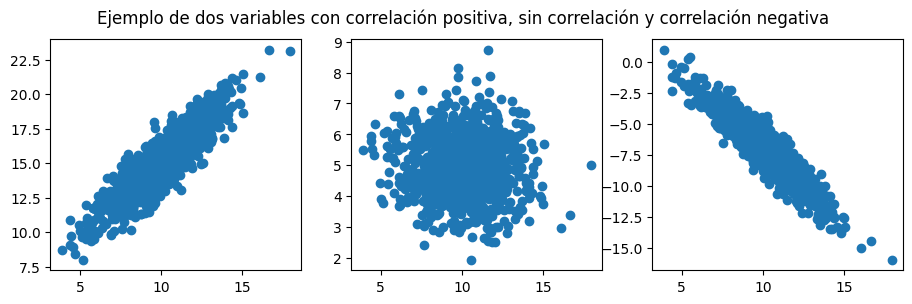

In [ ]:
# Generamos variables aleatorias correlacionadas
import numpy as np
import matplotlib.pyplot as plt

# Establecemos una semilla (para permitir replicabilidad)
np.random.seed(1)

# Generamos los datos
variable1 = 2 * np.random.randn(1000) + 10
variable2 = variable1 + (np.random.randn(1000) + 5)
variable3 = (np.random.randn(1000) + 5)
variable4 = -1.2*variable1 + (0.9*np.random.randn(1000) + 5)

# Estadísticos descriptivos
print('Variable 1: mean=%.3f stdv=%.3f' % (np.mean(variable1), np.std(variable1)))
print('Variable 2: mean=%.3f stdv=%.3f' % (np.mean(variable2), np.std(variable2)))
print('Variable 3: mean=%.3f stdv=%.3f' % (np.mean(variable3), np.std(variable3)))
print('Variable 4: mean=%.3f stdv=%.3f' % (np.mean(variable4), np.std(variable4)))

# Dibujamos los datos
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_size_inches(11, 3)
fig.suptitle('Ejemplo de dos variables con correlación positiva, sin correlación y correlación negativa')
ax1.scatter(variable1, variable2)
ax2.scatter(variable1, variable3)
ax3.scatter(variable1, variable4)

In [ ]:
# Construimos un dataframe con nuestras variables
np_data = np.concatenate((variable1.reshape(-1,1), variable2.reshape(-1,1),
                          variable3.reshape(-1,1), variable4.reshape(-1,1)),
                         axis = 1)
data = sqlContext.createDataFrame(np_data.tolist(), ["variable1", "variable2", "variable3", "variable4"])
data.show()

+------------------+------------------+------------------+-------------------+
|         variable1|         variable2|         variable3|          variable4|
+------------------+------------------+------------------+-------------------+
|13.248690727326483|18.095454565559393| 5.489516618141787|-10.967825133972445|
| 8.776487172699849|11.343978660052736| 5.238795857522951| -5.344741866658123|
| 8.943656495473089|14.451640832088469| 4.551888193906485|-4.8448114591217415|
| 7.854062755687659|12.530030426667652| 4.389204997151587| -3.135394522865262|
|11.730815258649358|15.219738650739155|2.9700549308147117|  -8.60154566081547|
| 5.396922606239435| 9.525500540644476| 5.607946586089135| -1.807265904828907|
| 13.48962352843296| 17.62479358696737|  4.64589111644031|-10.564999460687002|
| 8.477586198209794|14.086335280551495| 5.152581490121495| -5.891615511290131|
|10.638078192114197|16.199716288637603| 5.501274849040839| -7.573257876013867|
|  9.50125924904518| 16.01600963152743|4.21359722930

In [ ]:
# Lo convertimos a vector
from pyspark.ml.feature import VectorAssembler
assembler_2 = VectorAssembler(
  inputCols = ["variable1", "variable2", "variable3", "variable4"],
  outputCol = "features"
)
data = assembler_2.transform(data)

# Mostramos la nueva columa "features" para las 10 primeras filas del dataset
data.select("features").show(10, truncate=False)

+-----------------------------------------------------------------------------+
|features                                                                     |
+-----------------------------------------------------------------------------+
|[13.248690727326483,18.095454565559393,5.489516618141787,-10.967825133972445]|
|[8.776487172699849,11.343978660052736,5.238795857522951,-5.344741866658123]  |
|[8.943656495473089,14.451640832088469,4.551888193906485,-4.8448114591217415] |
|[7.854062755687659,12.530030426667652,4.389204997151587,-3.135394522865262]  |
|[11.730815258649358,15.219738650739155,2.9700549308147117,-8.60154566081547] |
|[5.396922606239435,9.525500540644476,5.607946586089135,-1.807265904828907]   |
|[13.48962352843296,17.62479358696737,4.64589111644031,-10.564999460687002]   |
|[8.477586198209794,14.086335280551495,5.152581490121495,-5.891615511290131]  |
|[10.638078192114197,16.199716288637603,5.501274849040839,-7.573257876013867] |
|[9.50125924904518,16.01600963152743,4.2

In [ ]:
# Como ya tenemos el vector podemos aplicar las técnicas
from pyspark.ml.stat import Correlation
pearson_corr = Correlation.corr(data, 'features', 'pearson').collect()[0][0]
print(pearson_corr)

DenseMatrix([[ 1.        ,  0.88761191, -0.05067561, -0.9302911 ],
             [ 0.88761191,  1.        , -0.05924545, -0.82133573],
             [-0.05067561, -0.05924545,  1.        ,  0.05990012],
             [-0.9302911 , -0.82133573,  0.05990012,  1.        ]])


In [ ]:
# Determinar la correlación entre las variables del dataset de Airbnb
pearson_corr = Correlation.corr(assembled_df, 'features', 'pearson').collect()[0][0]
print(pearson_corr)

DenseMatrix([[ 1.00000000e+00,  5.26152400e-03,  2.15644512e-02,
               2.73182960e-03, -2.48676580e-02,  9.15524830e-02,
              -9.91497245e-02, -1.70673416e-02],
             [ 5.26152400e-03,  1.00000000e+00, -1.91520083e-02,
              -3.50905820e-02,  1.79318662e-02,  6.48462459e-03,
              -7.16050371e-04, -1.49677383e-02],
             [ 2.15644512e-02, -1.91520083e-02,  1.00000000e+00,
               8.24975920e-01,  6.88681487e-02,  1.41329911e-01,
              -1.25957547e-01, -5.02585113e-02],
             [ 2.73182960e-03, -3.50905820e-02,  8.24975920e-01,
               1.00000000e+00,  7.76967491e-02,  1.79152509e-01,
              -1.64282995e-01, -5.18550134e-02],
             [-2.48676580e-02,  1.79318662e-02,  6.88681487e-02,
               7.76967491e-02,  1.00000000e+00,  4.14523381e-02,
              -4.90909392e-02,  5.45180314e-03],
             [ 9.15524830e-02,  6.48462459e-03,  1.41329911e-01,
               1.79152509e-01,  4.145233

## Regresión

Variable 1: mean=30.303 stdv=4.426


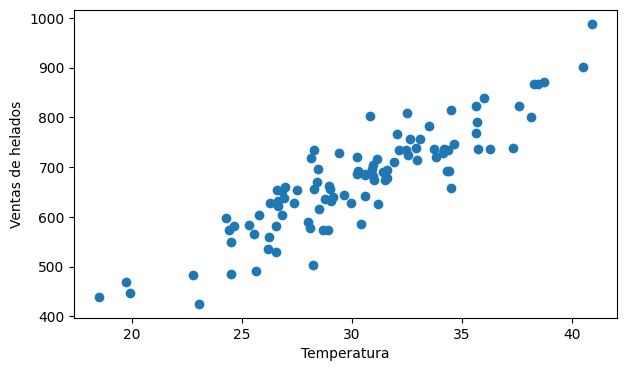

In [ ]:
# Generamos variables aleatorias correlacionadas
import numpy as np
import matplotlib.pyplot as plt

# Establecemos una semilla (para permitir replicabilidad)
np.random.seed(1)

# Generamos los datos
variable1 = 30 + 5*np.random.randn(100)
variable2 = 60 + 20 * variable1 + 50*np.random.randn(100)

# Estadísticos descriptivos
print('Variable 1: mean=%.3f stdv=%.3f' % (np.mean(variable1), np.std(variable1)))

# Dibujamos los datos
fig, ax1 = plt.subplots(1, 1)
fig.set_size_inches(7, 4)
ax1.set_xlabel('Temperatura')
ax1.set_ylabel('Ventas de helados')
ax1.scatter(variable1, variable2)

In [ ]:
# En este caso definimos un vector con cada una de las variables independientes (en este caso solo temperatura) dejando la variable dependiente (ventas) fuera
from pyspark.ml.feature import VectorAssembler
np_data = np.concatenate((variable1.reshape(-1,1), variable2.reshape(-1,1)),
                         axis = 1)
data = sqlContext.createDataFrame(np_data.tolist(), ["temperatura", "ventas"])

assembler_3 = VectorAssembler(
  inputCols = ["temperatura"],
  outputCol = "temperatura_vect"
)
data = assembler_3.transform(data)

data.show(10, truncate=False)

+------------------+-----------------+--------------------+
|temperatura       |ventas           |temperatura_vect    |
+------------------+-----------------+--------------------+
|38.121726818316205|800.0781081270242|[38.121726818316205]|
|26.941217931749623|660.0497438752674|[26.941217931749623]|
|27.35914123868272 |627.3574068631943|[27.35914123868272] |
|24.635156889219147|582.3820639462364|[24.635156889219147]|
|34.327038146623394|691.7951706454159|[34.327038146623394]|
|18.492306515598585|438.3152519649051|[18.492306515598585]|
|38.7240588210824  |871.5089989764617|[38.7240588210824]  |
|26.193965495524488|536.194279820093 |[26.193965495524488]|
|31.595195480285494|678.5929843055287|[31.595195480285494]|
|28.75314812261295 |636.6936897869268|[28.75314812261295] |
+------------------+-----------------+--------------------+
only showing top 10 rows



In [ ]:
from pyspark.ml.regression import LinearRegression

# Aplicar regresión lineal utilizando el método de mínimos cuadrados
lr = LinearRegression(featuresCol="temperatura_vect", labelCol="ventas")
lr_model = lr.fit(data)

print("Termino de interceptación: " + str(lr_model.intercept))
print("Coeficientes: " + str(lr_model.coefficients))

Termino de interceptación: 38.72253638955182
Coeficientes: [20.954271336511948]


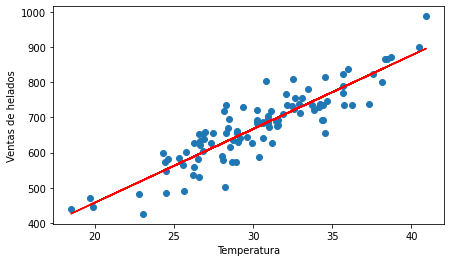

In [ ]:
# Dibujamos los datos
fig, ax1 = plt.subplots(1, 1)
fig.set_size_inches(7, 4)
ax1.set_xlabel('Temperatura')
ax1.set_ylabel('Ventas de helados')
ax1.scatter(variable1, variable2)

# Dibujamos la recta de regresión
y = lr_model.intercept + lr_model.coefficients[0]*variable1
plt.plot(variable1, y, 'r-')
plt.savefig("regresion.svg")